In [13]:
# importing necessary libraries 
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras

import pathlib
import cv2

In [19]:
image_shape = (224, 224)

# using mobilev2 model to classify images
classifier = tf.keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4", input_shape=image_shape+(3,))
])

In [20]:
image_shape + (3,)

(224, 224, 3)

In [21]:
# reading a parking meter image to test the model
image = cv2.imread("parkingmeter.jpg")
image = cv2.resize(image, image_shape)
image.shape

(224, 224, 3)

In [25]:
# scaling the image between 0, 1 to get a better performance 
image_scaled = image / 255

In [23]:
# model expects a 4dim input
image_scaled[np.newaxis,].shape

(1, 224, 224, 3)

In [33]:
pred = classifier.predict(image_scaled[np.newaxis,])

1/1 [==============================] - 0s 430ms/step


In [34]:
pred_index = pred.argmax()

In [24]:
# getting mobilev2 model labels/classes
image_labels = []
home_dir = str(pathlib.Path.home())

with open(fr"{home_dir}\source\ImageNetLabels.txt", "r") as f:
    image_labels = f.read().splitlines()
    
image_labels[:5]    

['background', 'tench', 'goldfish', 'great white shark', 'tiger shark']

In [36]:
image_labels[pred_index]

'parking meter'

In [28]:
# getting flower images dataset from the url below 
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = keras.utils.get_file("flower_photos", origin=dataset_url, cache_dir="~\source", untar=True)

In [29]:
data_dir

'C:\\Users\\Batlagh\\source\\datasets\\flower_photos'

In [30]:
flowers_path = pathlib.Path(data_dir)
flowers_path

WindowsPath('C:/Users/Batlagh/source/datasets/flower_photos')

In [41]:
list(flowers_path.glob("*"))

[WindowsPath('C:/Users/Batlagh/source/datasets/flower_photos/daisy'),
 WindowsPath('C:/Users/Batlagh/source/datasets/flower_photos/dandelion'),
 WindowsPath('C:/Users/Batlagh/source/datasets/flower_photos/roses'),
 WindowsPath('C:/Users/Batlagh/source/datasets/flower_photos/sunflowers'),
 WindowsPath('C:/Users/Batlagh/source/datasets/flower_photos/tulips')]

In [31]:
# creatintg a dict of flower classes and their images
flowers_dict = {
    "daisy": [str(path) for path in list(flowers_path.glob("daisy/*.jpg"))],
    "dandelion": [str(path) for path in list(flowers_path.glob("dandelion/*.jpg"))],
    "roses": [str(path) for path in list(flowers_path.glob("roses/*.jpg"))],
    "sunflowers": [str(path) for path in list(flowers_path.glob("sunflowers/*.jpg"))],
    "tulips": [str(path) for path in list(flowers_path.glob("tulips/*.jpg"))],
}

In [32]:
flowers_dict["roses"][:5]

['C:\\Users\\Batlagh\\source\\datasets\\flower_photos\\roses\\10090824183_d02c613f10_m.jpg',
 'C:\\Users\\Batlagh\\source\\datasets\\flower_photos\\roses\\102501987_3cdb8e5394_n.jpg',
 'C:\\Users\\Batlagh\\source\\datasets\\flower_photos\\roses\\10503217854_e66a804309.jpg',
 'C:\\Users\\Batlagh\\source\\datasets\\flower_photos\\roses\\10894627425_ec76bbc757_n.jpg',
 'C:\\Users\\Batlagh\\source\\datasets\\flower_photos\\roses\\110472418_87b6a3aa98_m.jpg']

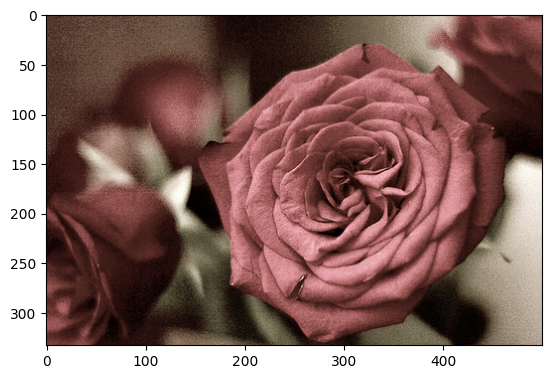

In [49]:
img = plt.imread(flowers_dict["roses"][12])
plt.imshow(img)
plt.show()

In [37]:
labels_dict = {
    "daisy": 0,
    "dandelion": 1,
    "roses": 2,
    "sunflowers": 3,
    "tulips": 4,
}

In [39]:
X = []
y = []

# getting every image and their classes from our flower dict and resizing them to 224x224
for flower_name, images in flowers_dict.items():
    for image in images:
        img = cv2.imread(image)
        img_resized = cv2.resize(img, (224, 224))
        X.append(img_resized)
        y.append(labels_dict[flower_name])

In [40]:
X = np.array(X)
y = np.array(y)

In [41]:
X.shape

(3670, 224, 224, 3)

In [42]:
from sklearn.model_selection import train_test_split
train_x, test_x , train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=10)

In [43]:
train_x = train_x / 255
test_x = test_x / 255

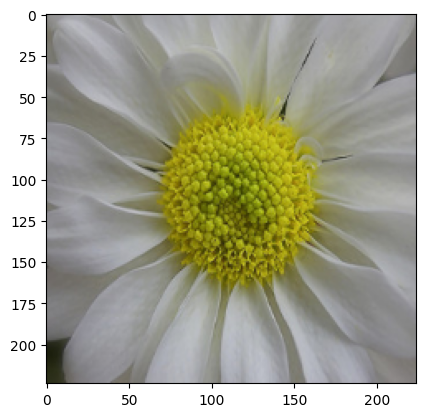

In [51]:
plt.imshow(cv2.cvtColor(X[0], cv2.COLOR_BGR2RGB))
plt.show()

In [52]:
# preparing samples to test model before adding extra dense layer to it
x0_resized = cv2.resize(X[0], image_shape)
x1_resized = cv2.resize(X[1], image_shape)
x2_resized = cv2.resize(X[2], image_shape)

In [53]:
x1_resized.shape

(224, 224, 3)

In [54]:
predicted = classifier.predict(np.array([x0_resized, x1_resized, x2_resized]))
predicted = np.argmax(predicted, axis=1)
predicted

1/1 [==============================] - 5s 5s/step


array([795, 795, 795], dtype=int64)

In [56]:
# as you see the model is not predicting very well  
image_labels[795]

'shower curtain'

In [57]:
# feature extractor will help the model to detect the features of our flowers images
url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
feature_extractor = keras.Sequential([
    hub.KerasLayer(url, trainable=False, input_shape=(224, 224,3))
])

In [58]:
# building model
model = keras.Sequential()
model.add(feature_extractor)
model.add(keras.layers.Dense(5, activation="softmax"))

model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

In [102]:
# training model
model.fit(train_x, train_y, epochs=5)

Epoch 1/5
92/92 [==============================] - 7s 40ms/step - loss: 0.7865 - accuracy: 0.7057
Epoch 2/5
92/92 [==============================] - 3s 36ms/step - loss: 0.4052 - accuracy: 0.8590
Epoch 3/5
92/92 [==============================] - 3s 36ms/step - loss: 0.3178 - accuracy: 0.8927
Epoch 4/5
92/92 [==============================] - 3s 36ms/step - loss: 0.2643 - accuracy: 0.9193
Epoch 5/5
92/92 [==============================] - 3s 35ms/step - loss: 0.2246 - accuracy: 0.9339


In [103]:
model.evaluate(test_x, test_y)

23/23 [==============================] - 2s 51ms/step - loss: 0.3523 - accuracy: 0.8801


[0.3522547483444214, 0.8801090121269226]